In [93]:
# This is code from PythonForFinance.net

In [1]:
import pandas as pd
import numpy as np
import math
from pandas_datareader import data
%matplotlib inline

In [2]:
file = 'C:\\Users\\txxv\\OneDrive - Chevron\\@ General Reference\\@ Reggie\\Trading Data\\SP500_historical_daily1962.csv'
#file = 'C:\\Users\\txxv\\OneDrive - Chevron\\@ General Reference\\@ Reggie\\Trading Data\\SP500_historical_daily.csv'
sp500 = pd.read_csv(file, index_col='Date', parse_dates=True)
sp500.sort_index(inplace=True)

In [4]:
sp500.head()

,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,
1962-01-02,71.550003,71.959999,70.709999,70.959999,3120000,70.959999
1962-01-03,70.959999,71.480003,70.379997,71.129997,3590000,71.129997
1962-01-04,71.129997,71.620003,70.449997,70.639999,4450000,70.639999
1962-01-05,70.639999,70.839996,69.349998,69.660004,4630000,69.660004
1962-01-08,69.660004,69.839996,68.169998,69.120003,4620000,69.120003


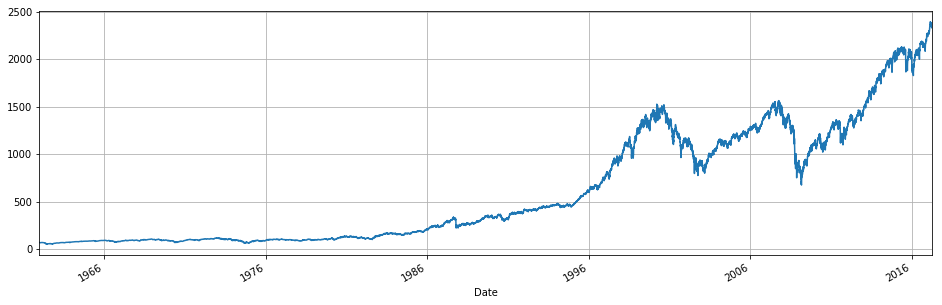

In [5]:
sp500['Close'].plot(grid=True, figsize=(16,5))

In [6]:
shortMA = 50
longMA = 200

sp500['ShortMA'] = np.round(sp500['Close'].rolling(window=shortMA).mean(),2)
sp500['LongMA'] = np.round(sp500['Close'].rolling(window=longMA).mean(),2)

In [7]:
sp500.tail()

,Open,High,Low,Close,Volume,Adj Close,ShortMA,LongMA
Date,,,,,,,,
2017-04-07,2356.590088,2363.760010,2350.739990,2355.540039,3053150000,2355.540039,2346.89,2221.84
2017-04-10,2357.159912,2366.370117,2351.500000,2357.159912,2785410000,2357.159912,2348.14,2223.06
2017-04-11,2353.919922,2355.219971,2337.250000,2353.780029,3117420000,2353.780029,2349.60,2224.64
2017-04-12,2352.149902,2352.719971,2341.179932,2344.929932,3196950000,2344.929932,2350.92,2226.37
2017-04-13,2341.979980,2348.260010,2328.949951,2328.949951,3143890000,2328.949951,2351.91,2227.83


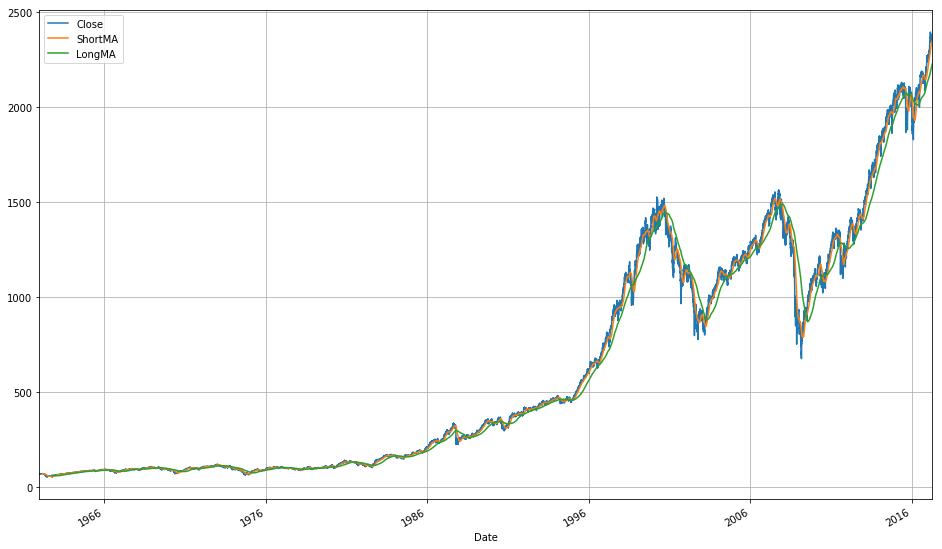

In [8]:
sp500[['Close','ShortMA', 'LongMA']].plot(grid=True, figsize=(16,10))

In [9]:
# Trading Rules
# 1) Buy Signal: go long when the 42d MA is X points above the 252d for the first time.
# 2) Park in Cash (no position)
# 3) Sell Signal: go short when the 42d MA is X points below the 252d MA for the first time.

In [10]:
# Create a column of the difference between the two MAs
sp500['ShortMA-LongMA'] = sp500['ShortMA'] - sp500['LongMA']

In [11]:
# Set signal threshold X
# Set "Stance", which represents our position: long = 1, short = -1, no position = 0
X = 0
sp500['Stance'] = np.where(sp500['ShortMA-LongMA'] > X, 1, 0)
sp500['Stance'] = np.where(sp500['ShortMA-LongMA'] < X, -1, sp500['Stance'])

In [12]:
# Count the number of train types
sp500['Stance'].value_counts()

 1    9570
-1    4146
 0     201
Name: Stance, dtype: int64

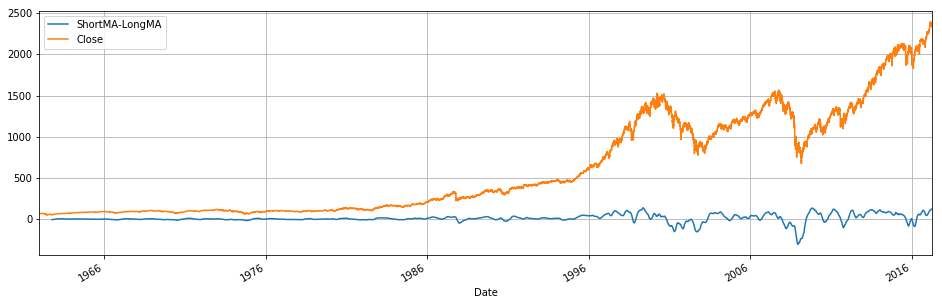

In [13]:
sp500[['ShortMA-LongMA','Close']].plot(grid=True,figsize=(16,5))

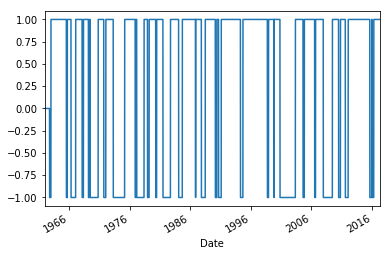

In [14]:
sp500['Stance'].plot(lw=1.5, ylim=[-1.1, 1.1])

In [15]:
# Calculate market returns by multiplying daily market returns by the Stance

#Calculate daily log returns
sp500['Market Returns'] = np.log(sp500['Close']) / sp500['Close'].shift(1)

#Calculate strategy returns
sp500['Strategy Returns'] = sp500['Market Returns'] * sp500['Stance'].shift(1)

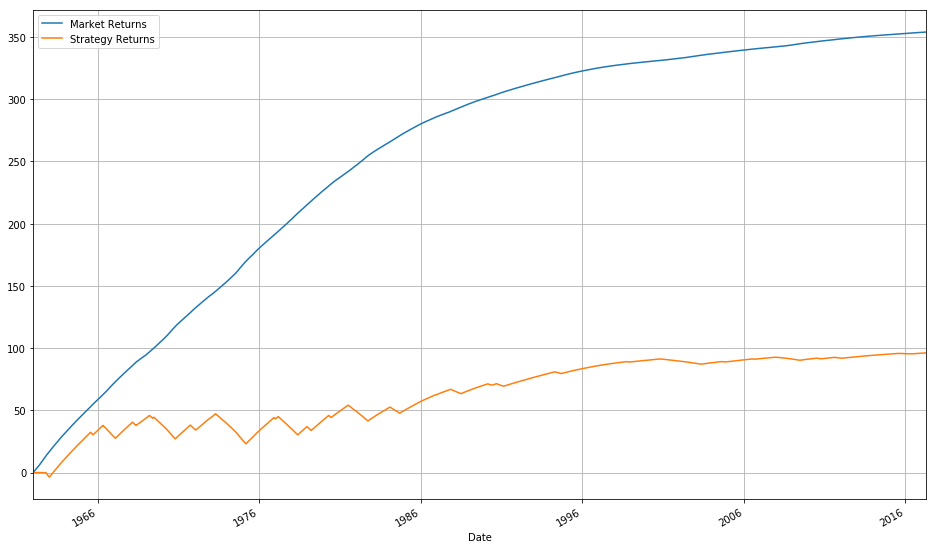

In [16]:
sp500[['Market Returns', 'Strategy Returns']].cumsum().plot(grid=True, figsize=(16,10))

In [17]:
sp500.tail()

,Open,High,Low,Close,Volume,Adj Close,ShortMA,LongMA,ShortMA-LongMA,Stance,Market Returns,Strategy Returns
Date,,,,,,,,,,,,
2017-04-07,2356.590088,2363.760010,2350.739990,2355.540039,3053150000,2355.540039,2346.89,2221.84,125.05,1,0.003294,0.003294
2017-04-10,2357.159912,2366.370117,2351.500000,2357.159912,2785410000,2357.159912,2348.14,2223.06,125.08,1,0.003297,0.003297
2017-04-11,2353.919922,2355.219971,2337.250000,2353.780029,3117420000,2353.780029,2349.60,2224.64,124.96,1,0.003294,0.003294
2017-04-12,2352.149902,2352.719971,2341.179932,2344.929932,3196950000,2344.929932,2350.92,2226.37,124.55,1,0.003297,0.003297
2017-04-13,2341.979980,2348.260010,2328.949951,2328.949951,3143890000,2328.949951,2351.91,2227.83,124.08,1,0.003306,0.003306


In [18]:
sp500[['Market Returns', 'Strategy Returns']].cumsum().tail(1)

,Market Returns,Strategy Returns
Date,,
2017-04-13,353.984927,96.144331


In [19]:
# Set strategy starting equity to 1 (i.e. 100%) and generate equity curve
sp500['Strategy Equity'] = sp500['Strategy Returns'].cumsum() + 1

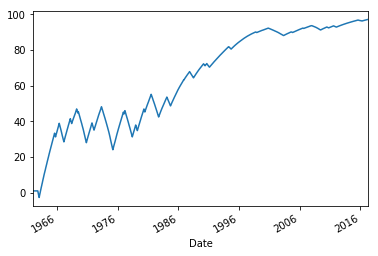

In [20]:
# Show chart of equity curve
sp500['Strategy Equity'].plot()

In [21]:
# Create new dataframe to analyze the strategy's performance
strat = pd.DataFrame([sp500['Strategy Equity'], sp500['Strategy Returns']]).transpose()

In [22]:
# Create columns that indicate whether each day's returns were positive, negative, or flat.
strat['win'] = (np.where(strat['Strategy Returns'] > 0, 1, 0))
strat['loss'] = (np.where(strat['Strategy Returns'] < 0, 1, 0))
strat['scratch'] = (np.where(strat['Strategy Returns'] == 0, 1, 0))

# Create columns with a cumulative sum of each of the columns created above
strat['wincum'] = (np.where(strat['Strategy Returns'] > 0, 1, 0)).cumsum()
strat['losscum'] = (np.where(strat['Strategy Returns'] < 0, 1, 0)).cumsum()
strat['scratchcum'] = (np.where(strat['Strategy Returns'] == 0, 1, 0)).cumsum()

# Create a column that holds a running sum of trading days - we will use this to create our percentages later
strat['days'] = (strat['wincum'] + strat['losscum'] + strat['scratchcum'])

# Create columns that shows the 252 day rolling sum of the winning/losing/flat days
strat['rollwin'] = strat['win'].rolling(window=252).sum()
strat['rollloss'] = strat['loss'].rolling(window=252).sum()
strat['rollscratch'] = strat['scratch'].rolling(window=252).sum()

# Create columns with hit ratio and loss ratio data
strat['hitratio'] = strat['wincum'] / (strat['wincum']+strat['losscum'])
strat['lossratio'] = 1 - strat['hitratio']

# Create columns with rolling 252 day hit ratio and loss ratio data
strat['rollhitratio'] = strat['hitratio'].rolling(window=252).mean()
strat['rolllossratio'] = 1 - strat['rollhitratio']

# Create column with rolling 12 month return
strat['roll12mret'] = strat['Strategy Returns'].rolling(window=252).sum()

# Create column with average win, average loss, and average daily return data
strat['averagewin'] = strat['Strategy Returns'][(strat['Strategy Returns'] > 0)].mean()
strat['averageloss'] = strat['Strategy Returns'][(strat['Strategy Returns'] < 0)].mean()
strat['averagedailyret'] = strat['Strategy Returns'].mean()

# Create column with rolling 1 year daily standard deviation and rolling 1 year annualized standard deviation
strat['roll12mstdev'] = strat['Strategy Returns'].rolling(window=252).std()
strat['roll12mannualizedvol'] = strat['roll12mstdev'] * math.sqrt(252)

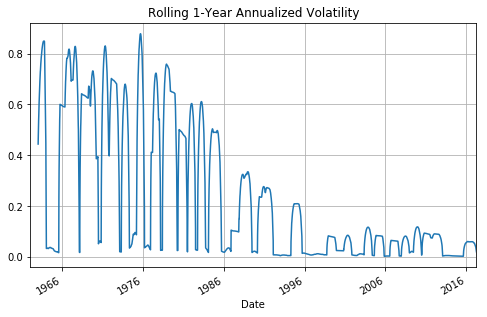

In [23]:
strat['roll12mannualizedvol'].plot(grid=True, figsize=(8,5), title='Rolling 1-Year Annualized Volatility')

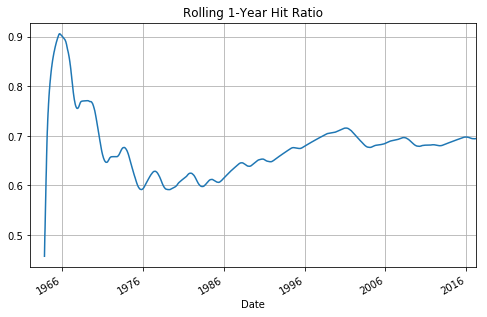

In [24]:
strat['rollhitratio'].plot(grid=True,figsize=(8,5),title='Rolling 1-Year Hit Ratio')

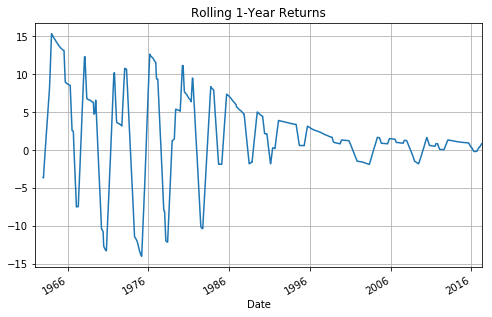

In [25]:
strat['roll12mret'].plot(grid=True, figsize=(8,5), title='Rolling 1-Year Returns')

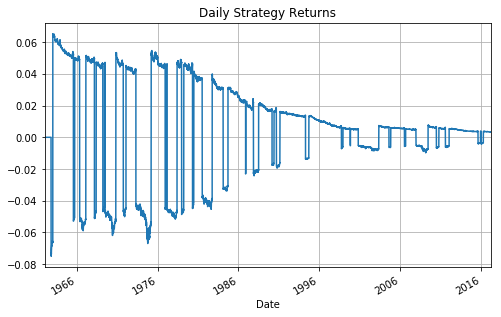

In [26]:
strat['Strategy Returns'].plot(grid=True,figsize=(8,5),title='Daily Strategy Returns')

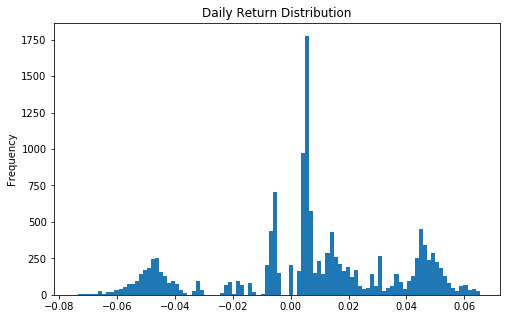

In [27]:
strat['Strategy Returns'].plot(kind='hist',figsize=(8,5),title='Daily Return Distribution', bins=100)

In [28]:
print("Skew: ", round(strat['Strategy Returns'].skew(),4))
print("Kurtosis: ", round(strat['Strategy Returns'].kurt(),4))

Skew:  -0.4148
Kurtosis:  -0.3461


In [29]:
# Create some key performance indicators typical for evaluating a strategy
# 1) Annualized Return
# 2) Last 12 months return
# 3) Volatility
# 4) Sharpe Ratio
# 5) Maximum Drawdown
# 6) Calmar Ratio (Annualized Return /  Max Drawdown)
# 7) Volatility / Max Drawdown
# 8) Best Month Performance
# 9) Worst Month Performance
# 10) % of Profitable Months and % Un-Profitable Months
# 11) Nbr of Profitable Months / Nbr of Un-Profitable Months
# 12) Avarage Monthly Profit
# 13) Average Monthly Loss
# 14) Average Monthly Profit / Average Monthly Loss

In [30]:
# Create a new DataFrame to hold our monthly data,...
# ...populate it with the data from the daily returns column of our original DataFrame, ...
# ...and sum it by month
stratm = pd.DataFrame(strat['Strategy Returns'].resample('M').sum())

# Build the monthly data equity curve
stratm['Strategy Equity'] = stratm['Strategy Returns'].cumsum()+1

# Add a column that holds the numerical monthly index (i.e. Jan=1, Feb=2, etc.)
stratm['month'] = stratm.index.month


In [31]:
stratm.head(15)

,Strategy Returns,Strategy Equity,month
Date,,,
1962-01-31,0.000000,1.000000,1
1962-02-28,0.000000,1.000000,2
1962-03-31,0.000000,1.000000,3
1962-04-30,0.000000,1.000000,4
1962-05-31,0.000000,1.000000,5
1962-06-30,0.000000,1.000000,6
1962-07-31,0.000000,1.000000,7
1962-08-31,0.000000,1.000000,8
1962-09-30,0.000000,1.000000,9


In [32]:
# 1) Annualized Return
days = (strat.index[-1] - strat.index[0]).days
cagr = ((((strat['Strategy Equity'][-1] / strat['Strategy Equity'][1])) ** (365.0/days)))
print('CAGR = ', str(round(cagr,4)*100)+'%')

CAGR =  108.62%


In [33]:
# 2) Last 12 months Return
stratm['last12mret'] = stratm['Strategy Returns'].rolling(window=12,center=False).sum()
last12mret = stratm['last12mret'][-1]
print('last 12 month return = ', str(round(last12mret*100,2))+'%')

last 12 month return =  84.43%


In [35]:
# 3) Volatility
voldaily = (strat['Strategy Returns'].std()) * math.sqrt(252)
volmonthly = (stratm['Strategy Returns'].std()) * math.sqrt(12)
print('Annualized volatility using daily data = ',str(round(voldaily*100,4))+'%')
print('Annualized volatility using monthly data = ',str(round(volmonthly*100,4))+'%')

Annualized volatility using daily data =  48.3444%
Annualized volatility using monthly data =  214.1945%


In [39]:
# 4) Sharpe Ratio
dailysharpe = cagr/voldaily
monthlysharpe = cagr/volmonthly
print('daily Sharpe = ', round(dailysharpe,2))
print('monthly Sharpe = ', round(monthlysharpe,2))

daily Sharpe =  2.25
monthly Sharpe =  0.51


In [47]:
# 5) Max Drawdown
# Create max drawdown function
def max_drawdown(X):
    mdd = 0
    peak = max(0,X[0])
    for x in X:
        if x > peak:
            peak = x
        dd = (peak - x) / peak
        if dd > mdd:
            mdd = dd
    return mdd

mdd_daily = max_drawdown(strat['Strategy Equity'])
mdd_monthly = max_drawdown(stratm['Strategy Equity'])
print('max drawdown daily data = ', str(round(mdd_daily,4)*100)+'%')
print('max drawdown monthly data = ', str(round(mdd_monthly,4)*100)+'%')

max drawdown daily data =  369.16%
max drawdown monthly data =  355.97%


In [49]:
# 6) Calmar Ratio
calmar = cagr/mdd_daily
print('Calmar ratio = ', round(calmar,2))

Calmar ratio =  0.29


In [50]:
# 7) Volatility / Max Drawdown
vol_dd = volmonthly / mdd_daily
print('Volatility / Max Drawdown = ', round(vol_dd,2))

Volatility / Max Drawdown =  0.58


In [52]:
# 8) Best Month Performance
bestmonth = max(stratm['Strategy Returns'])
print('Best month = ', str(round(bestmonth, 2))+'%')

Best month =  1.35%


In [53]:
# 9) Worst Month Performance
worstmonth = min(stratm['Strategy Returns'])
print('Worst month = ', str(round(worstmonth, 2)*100)+'%')

Worst month =  -142.0%


In [54]:
# 10) % of Profitable Months & % Non-Profitable Months
positive_months = len(stratm['Strategy Returns'][stratm['Strategy Returns'] > 0])
negative_months = len(stratm['Strategy Returns'][stratm['Strategy Returns'] < 0])
flatmonths = len(stratm['Strategy Returns'][stratm['Strategy Returns'] == 0])
perc_positive_months = positive_months / (positive_months + negative_months + flatmonths)
perc_negative_months = negative_months / (positive_months + negative_months + flatmonths)
print('% of Profitable Months = ', str(round(perc_positive_months,2)*100)+'%')
print('% of Non-profitable Months = ', str(round(perc_negative_months, 2)*100)+'%')

% of Profitable Months =  69.0%
% of Non-profitable Months =  30.0%


In [55]:
# 11) Number of Profitable Months/Number of Non-Profitable Months
prof_unprof_months = positive_months / negative_months
print('Number of Profitable Months/Number of Non-Profitable Months = ', round(prof_unprof_months,2))

Number of Profitable Months/Number of Non-Profitable Months =  2.31


In [57]:
# 12) Average Monthly Profit
av_monthly_pos = (stratm['Strategy Returns'][stratm['Strategy Returns'] > 0]).mean()
print('Average Monthly Profit = ', str(round(av_monthly_pos,4)*100)+'%')
                                             
# 13) Average Monthly Loss
av_monthly_neg = (stratm['Strategy Returns'][stratm['Strategy Returns'] < 0]).mean()
print('Average Monthly Loss = ', str(round(av_monthly_neg*100,2))+'%')

# 14) Average Monthly Profit/Average Monthly Loss
pos_neg_month = abs(av_monthly_pos / av_monthly_neg)
print('Average Monthly Profit/Average Monthly Loss = ', round(pos_neg_month, 4))

Average Monthly Profit =  46.23%
Average Monthly Loss =  -58.14%
Average Monthly Profit/Average Monthly Loss =  0.7951


In [58]:
# Create a table of monthly returns
# Create a pivot table and resample it to create a pandas.tseries.resample.DatetimeIndexResampler object
monthly_table = stratm[['Strategy Returns', 'month']].pivot_table(stratm[['Strategy Returns', 'month']], 
                                                                  index=stratm.index, 
                                                                  columns='month', 
                                                                  aggfunc=np.sum).resample('A')

# Convert object into a DataFrame using the aggregate() function
monthly_table = monthly_table.aggregate('sum')

# Drop the top level column index which currently shows as 'Strategy'
monthly_table.columns = monthly_table.columns.droplevel()

# Replace full date in index column with just the corresponding year
monthly_table.index = monthly_table.index.year

# Replace integer column headings with MMM format
monthly_table.columns = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

In [59]:
monthly_table

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Date,,,,,,,,,,,,
1962,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.866156,-1.371257,-1.322330
1963,1.151395,1.205370,1.340442,1.295168,1.334101,1.211205,1.348805,1.324122,1.176698,1.353456,1.061645,1.220649
1964,1.249478,1.068251,1.164639,1.206145,1.088461,1.203236,1.169822,1.127694,1.115331,1.151884,0.988862,1.161104
1965,1.036575,0.977491,1.181657,1.070575,1.005876,1.146631,0.466461,-1.135687,-0.158334,1.038847,0.981360,1.084188
1966,1.021041,0.927669,1.160172,0.888404,-1.077554,-1.138076,-1.036869,-1.248636,-1.174901,-1.186352,-1.085332,-1.135764
1967,-1.107533,0.662934,1.107594,0.994033,1.073457,1.087482,0.977106,1.106653,0.954023,1.047462,0.977986,0.957591
1968,1.052258,0.742970,-1.058781,-0.957205,-0.182550,0.779756,0.780360,0.841947,0.776534,0.805667,0.753429,0.787352
1969,0.996898,0.817632,-0.091598,-0.958634,-0.753968,0.499701,-1.006721,-1.015424,-1.009586,-1.100202,-0.900419,-1.088581
1970,-1.043429,-0.976627,-1.062536,-1.135953,-1.193956,-1.256376,-1.262027,-1.176888,-1.126466,-0.519509,1.054660,1.102334
